In [21]:
import cv2 
import torch
import numpy as np 
import torch.nn as nn 
from torchvision import transforms
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import matplotlib.pyplot as plt 

from tqdm.auto import tqdm

In [22]:
def show(tensor,epoch ,channel = 1 , size = (28,28), num = 16 ):

    # tensor : 128 * 28 * 28
    data=tensor.detach().cpu().view(-1,channel,*size) #-> 128,1,28,28
    grid = make_grid(data[:num], nrow= 4).permute(1,2,0)# 1X28X28 -> 28x28x1
    plt.imshow(grid)
    # plt.show()
    plt.savefig(f"mnist_generated/{epoch}.png")


In [23]:
# hyperparameters and parameters: 
EPOCHS = 500
BATCH_SIZE = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cuda:1"
current_step = 0
info_step = 500 #kun kun step ma visually show garene

mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64 # dim of noise vector 
lr = 0.0001
loss_fn = nn.BCEWithLogitsLoss()



In [24]:
dataloader = DataLoader(MNIST('.',download=True, transform= transforms.ToTensor()), shuffle= True, batch_size=BATCH_SIZE)

In [25]:
# The generator 
def genBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True)
    )

class Generator(nn.Module):
    def __init__(self, z_dim=64, i_dim=784, h_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim), # 64, 128
            genBlock(h_dim, h_dim*2), # 128, 256
            genBlock(h_dim*2, h_dim*4), # 256 x 512
            genBlock(h_dim*4, h_dim*8), # 512, 1024
            nn.Linear(h_dim*8, i_dim), # 1024, 784 (28x28)
            nn.Sigmoid(),
        )

    def forward(self, noise):
        return self.gen(noise)


def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(DEVICE)    


In [26]:
# The discriminator 

def disc_block(inp , opt):

    return nn.Sequential(
        nn.Linear(in_features=inp, out_features= opt),
        nn.LeakyReLU(0.2)
    )


class Discriminator(nn.Module):
    def __init__(self, i_dim = 784 , h_dim = 128) -> None:
        super().__init__()

        self.disc = nn.Sequential(
            disc_block(i_dim , h_dim * 4),
            disc_block(h_dim * 4 , h_dim * 2 ),
            disc_block(h_dim * 2 , h_dim),
            nn.Linear(h_dim  , 1)
        )
    
    def forward(self, noise):
        return self.disc(noise)

In [27]:

gen = Generator(z_dim).to(DEVICE)
gen_opt  = torch.optim.Adam(params= gen.parameters(), lr = lr)

disc = Discriminator().to(DEVICE)
disc_opt = torch.optim.Adam(params= disc.parameters(), lr = lr)

torch.Size([256, 1, 28, 28]) torch.Size([256])
tensor([2, 9, 5, 5, 4, 1, 2, 9, 1, 9])


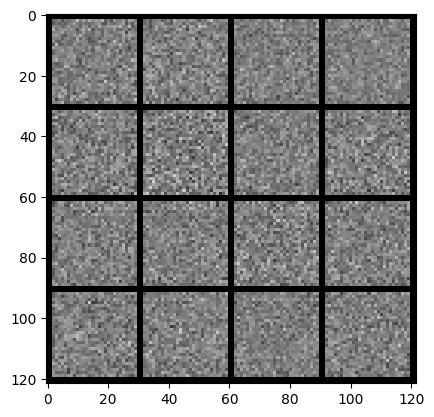

In [28]:
x,y = next(iter(dataloader))
print(x.shape,y.shape)
print(y[:10])

nosie = gen_noise(BATCH_SIZE ,z_dim)
fake = gen(nosie)

show(fake,'noise')

In [29]:
# calclaute the loss 

def cal_gen_loss(loss_fn , gen , disc, number, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    pred = disc(fake)

    targets = torch.ones_like(pred)
    generator_loss = loss_fn(pred,targets)

    return generator_loss

def cal_disc_loss(loss_fn, gen, disc, number, real, z_dim):

    noise = gen_noise(number , z_dim)
    fake = gen(noise)
    
    # we dont want change the parameters of generator when we are 
    # upadating the discriminator. so we detach.
    disc_fake = disc(fake.detach() )
    disc_fake_targets = torch.zeros_like(disc_fake)
    disc_fake_loss = loss_fn(disc_fake, disc_fake_targets)

    disc_real = disc(real)
    disc_real_targets = torch.ones_like(disc_real)
    disc_real_loss = loss_fn(disc_real, disc_real_targets)

    disc_loss = (disc_fake_loss + disc_real_loss) / 2 

    return disc_loss




In [30]:
# Trainig loop: 
gen_loss_list = []
disc_loss_list = []
for epoch in range(EPOCHS):
    print(f"Epoch : {epoch + 1 } / {EPOCHS}")
    # print(f"{epoch+1}/{EPOCHS}")
    iterations = 0
    gen_iter_loss = 0.0
    disc_iter_loss = 0.0
    train_bar = tqdm(dataloader, desc=f"Training")
    for batch_idx, (real, _) in enumerate(train_bar):

        ### discriminator 
        disc_opt.zero_grad()

        current_batch_size = len(real) # BATCH_SIZE 128X1X28X28
        real = real.view(current_batch_size , -1 ) # BATCH_SIZE * 728
        real = real.to(DEVICE)
        disc_loss = cal_disc_loss(loss_fn, gen , disc, current_batch_size, real , z_dim)

        disc_loss.backward(retain_graph = True)
        disc_opt.step()

        ### generator 
        gen_opt.zero_grad()
        gen_loss = cal_gen_loss(loss_fn,gen, disc,current_batch_size, z_dim )
        gen_loss.backward(retain_graph = True)
        gen_opt.step()


        ### visualization
        gen_iter_loss += disc_loss.item()
        disc_iter_loss += gen_loss.item() 




        iterations+=1
        train_bar.set_postfix(
            gen_loss = gen_iter_loss/( batch_idx + 1), 
            disc_loss = disc_iter_loss / (batch_idx + 1 )
        )


    gen_loss_list.append(gen_iter_loss/iterations)
    disc_loss_list.append(disc_iter_loss/iterations)
    if epoch % 5 == 0:
        print(f"Epoch:{epoch}: / Gen loss: {gen_loss_list[-1]} / disc_loss: {disc_loss_list[-1]}")
        fake_noise = gen_noise(current_batch_size, z_dim)
        fake = gen(fake_noise)
        show(fake , epoch)





Epoch : 1 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:0: / Gen loss: 0.29767859555939413 / disc_loss: 3.1140320780429436
Epoch : 2 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 3 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 4 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 5 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 6 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:5: / Gen loss: 0.052692232756538594 / disc_loss: 4.88385456470733
Epoch : 7 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 8 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 9 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 10 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 11 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:10: / Gen loss: 0.07150992486388125 / disc_loss: 5.380966973812022
Epoch : 12 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 13 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 14 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 15 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 16 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:15: / Gen loss: 0.08012109061187886 / disc_loss: 4.915262822901949
Epoch : 17 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 18 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 19 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 20 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 21 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:20: / Gen loss: 0.05228903220689043 / disc_loss: 5.224815744034787
Epoch : 22 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 23 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 24 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 25 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 26 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:25: / Gen loss: 0.05641909285270153 / disc_loss: 5.393439794094005
Epoch : 27 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 28 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 29 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 30 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 31 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:30: / Gen loss: 0.046778639588267244 / disc_loss: 5.2330774165214375
Epoch : 32 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 33 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 34 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 35 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 36 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:35: / Gen loss: 0.06909386793032606 / disc_loss: 4.730532850103176
Epoch : 37 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 38 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 39 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 40 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 41 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:40: / Gen loss: 0.08742725427480454 / disc_loss: 4.515078579111302
Epoch : 42 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 43 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 44 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 45 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 46 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:45: / Gen loss: 0.06149790975007605 / disc_loss: 5.088870949440814
Epoch : 47 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 48 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 49 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 50 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 51 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch:50: / Gen loss: 0.05024484449086037 / disc_loss: 4.881470408338181
Epoch : 52 / 500


Training:   0%|          | 0/235 [00:00<?, ?it/s]